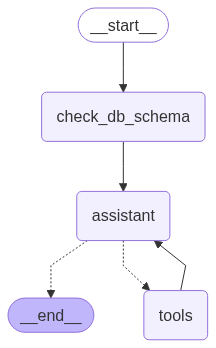

In [2]:
from IPython.display import Image, display

from app.agent import graph

display(Image(graph.get_graph().draw_mermaid_png()))